# HW 1 
## Homework 1 for SOCS course 
### Viggo Wessner 

#### **Exercise 1. Brownian disk with Lennard Jones potential**
Simulate a Brownian disk (see Fig. 1.8 in the book). Start with a single disk (radius Rdisk, mass mdisk) and
N 2
part particles (point-like, mass m). The particles do not mutually interact. The interaction happens only
among the disk and the particles through a Lennard-Jones potential (parameters: σ = 1, $\epsilon$ = 1).
The system is enclosed in a squared box with reflecting boundaries. The size of the box is L × L. Initially, the
particles are positioned on a squared lattice. They have a velocity with random orientation and magnitude v.
The disk start from the center of the box from rest (i.e., its velocity is 0). In the simulation, use the following
parameters:
##### **P1** - trajectory of the disk in the Cartesian plane.



Number of particles after filter 620


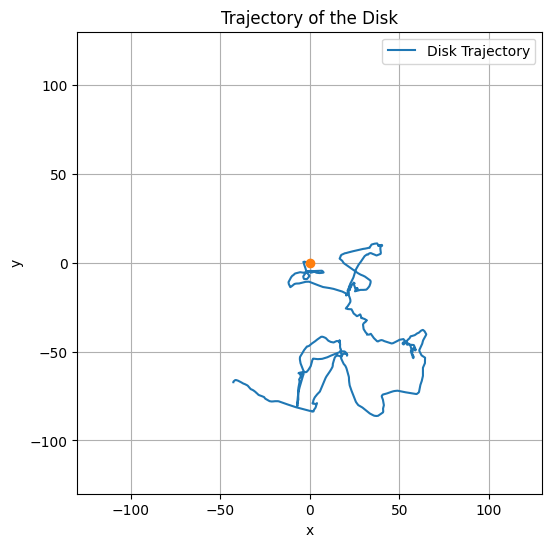

In [2]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 1
eps = 1


m_p = 1
v0_p = 10
N_p = 25*25

m_d = 10
R_d = 10
vx_d = 0
vy_d = 0
L = 260

T = 400
dt = 0.005


x_min, x_max, y_min, y_max = -L/2, L/2, -L/2, L/2



x_d = 0
y_d = 0


# Generate initial positions on a grid and orientations at random.
x0, y0 = np.meshgrid(
    np.linspace(- L / 2, L / 2, int(np.ceil(np.sqrt(N_p)))),
    np.linspace(- L / 2, L / 2, int(np.ceil(np.sqrt(N_p)))),
)
x0 = x0.flatten()[:N_p]
y0 = y0.flatten()[:N_p]
phi0 = (2 * np.random.rand(N_p) - 1) * np.pi


# Filter out particles within 3σ of disk rim
filtered_indices = []
for i in range(N_p):
    r = np.sqrt((x_d - x0[i])**2 + (y_d - y0[i])**2)
    if r >= R_d + 3 * sigma:
        filtered_indices.append(i)

# Initialize the variables for the leapfrog algorithm.
# Current time srep.
N_p = len(filtered_indices)
print("Number of particles after filter", N_p)

x_d_half = 0
y_d_half = 0
x = x0[filtered_indices]
y = y0[filtered_indices]


x_half = np.zeros(N_p)
y_half = np.zeros(N_p)
v = v0_p
phi = phi0[filtered_indices]
vx = v0_p * np.cos(phi)
vy = v0_p* np.sin(phi)

# Next time step.
nx_d = 0
ny_d = 0
nvx_d = 0
nvy_d = 0
nx = np.zeros(N_p)
ny = np.zeros(N_p)
nv = np.zeros(N_p)
nphi = np.zeros(N_p)
nvx = np.zeros(N_p)
nvy = np.zeros(N_p)




def lennard_jones_force(r):
    """Calculate Lennard-Jones force."""
    if r <= 0:
        return 0
    return 24 * (eps/r) * ((2 * (sigma / r)**12) - ((sigma / r)**6)) 



def total_force(x,y, x_d, y_d, N_p):
    """
    Calculate the total Lennard-Jones force on the disk from all particles.

    Returns:
        Fx: Total force in x-direction on the disk
        Fy: Total force in y-direction on the disk
        Fx_p: Array of forces in x-direction on each particle
        Fy_p: Array of forces in y-direction on each particle
    """
    Fx = 0
    Fy = 0
    Fx_p = np.zeros(N_p)
    Fy_p = np.zeros(N_p)

    for i in range(N_p):
        dx = x_d - x[i]
        dy = y_d - y[i]
        distance = np.sqrt(dx**2 + dy**2)
        r = distance - R_d
        if r > 0:
            F = lennard_jones_force(r)
            Fx_component = F * (dx) / distance
            Fy_component = F * (dy) / distance
            Fx += Fx_component
            Fy += Fy_component
            Fx_p[i] -= Fx_component
            Fy_p[i] -= Fy_component

    return Fx, Fy, Fx_p, Fy_p



disc_velocities = []
disc_positions = []
num_steps = int(T / dt)
for step in range(num_steps):
    #Half step stuff for leapfrog
    x_half = x + 0.5*vx*dt
    y_half = y + 0.5*vy*dt

    x_d_half = x_d + 0.5*vx_d*dt
    y_d_half = y_d + 0.5*vy_d*dt

    fx, fy, fx_p, fy_p = total_force(x_half, y_half, x_d_half, y_d_half, N_p)
#Disc stuff
    nvx_d = vx_d + (fx/m_d) * dt
    nvy_d = vy_d + (fy/m_d) * dt

    nx_d = x_d + + 0.5*nvx_d*dt
    ny_d = y_d + 0.5*nvy_d*dt

#Particle stuff

    nvx = vx + (fx_p / m_p) * dt
    nvy = vy + (fy_p / m_p) * dt

    nx = x_half + 0.5 * nvx * dt
    ny = y_half + 0.5 * nvy * dt


    
    #Reflect boundary conditions for particles and check if touch disc
    for j in range(N_p):
        if nx[j] < x_min:
            nx[j] = x_min + (x_min - nx[j])
            nvx[j] = - nvx[j]

        if nx[j] > x_max:
            nx[j] = x_max - (nx[j] - x_max)
            nvx[j] = - nvx[j]

        if ny[j] < y_min:
            ny[j] = y_min + (y_min - ny[j])
            nvy[j] = - nvy[j]
            
        if ny[j] > y_max:
            ny[j] = y_max - (ny[j] - y_max)
            nvy[j] = - nvy[j]
        

    # Reflect disc at boundaries
        if (nx_d - R_d < x_min) or (nx_d + R_d > x_max):
            nvx_d = -nvx_d
        # Adjust position to lie within boundaries
        if nx_d - R_d < x_min:
            nx_d = x_min + R_d
        if nx_d + R_d > x_max:
            nx_d = x_max - R_d

        if (ny_d - R_d < y_min) or (ny_d + R_d > y_max):
            nvy_d = -nvy_d
        # Adjust position to lie within boundaries
        if ny_d - R_d < y_min:
            ny_d = y_min + R_d
        if ny_d + R_d > y_max:
            ny_d = y_max - R_d


    #Store disc pos
    disc_positions.append((x_d, y_d))
    disc_velocities.append((vx_d, vy_d))

    # Update variables for next iteration
    x = nx
    y = ny
    vx = nvx
    vy = nvy
    x_d = nx_d
    y_d = ny_d
    vx_d = nvx_d
    vy_d = nvy_d

disc_positions = np.array(disc_positions)

# Plot P1: Trajectory of the disk
plt.figure(figsize=(6, 6))
plt.plot(disc_positions[:, 0], disc_positions[:, 1], label="Disk Trajectory")
plt.plot(disc_positions[0,0], disc_positions[0,1], "-o")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Trajectory of the Disk")
plt.legend()
plt.xlim(-L/2, L/2)
plt.ylim(-L/2, L/2)
plt.grid(True)
plt.show()


##### **P2** - plot MSD as a function of time $t=n\Delta t$, calculated as: $$MSD(n\Delta t) =\frac{1}{N-n}\sum_{i=1}^{N-n}(X_{i+n}- X_i)^2 + (Y_{i+n} - Y_i)^2$$

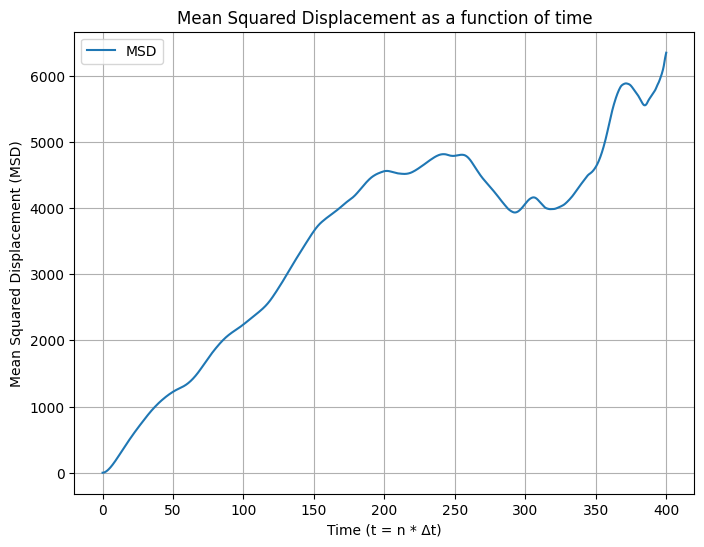

In [3]:

def MSD(disc_positions):
    N = len(disc_positions)  # Total number of time steps
    msd = np.zeros(N - 1)    # We only need N-1 steps for MSD

    # Loop over lag times (n)
    for n in range(1, N):
        # Calculate squared displacements for each lag time `n`
        dx = disc_positions[n:, 0] - disc_positions[:N-n, 0]  # Displacement in x
        dy = disc_positions[n:, 1] - disc_positions[:N-n, 1]  # Displacement in y
        squared_displacement = dx**2 + dy**2
        msd[n - 1] = (np.sum(squared_displacement))/ (N-n)           # Mean of squared displacements

    return msd


msd_values = MSD(disc_positions)
msd_times = np.arange(1, len(msd_values) + 1) * dt


plt.figure(figsize=(8, 6))
plt.plot(msd_times, msd_values, label='MSD' )
plt.xlabel('Time (t = n * Δt)')
plt.ylabel('Mean Squared Displacement (MSD)')
plt.title('Mean Squared Displacement as a function of time')
plt.legend()
plt.grid()
plt.show()

        

##### **Q1** - Calculate an estimate for $D$, given that $MSD(\tau)=4D\tau$.

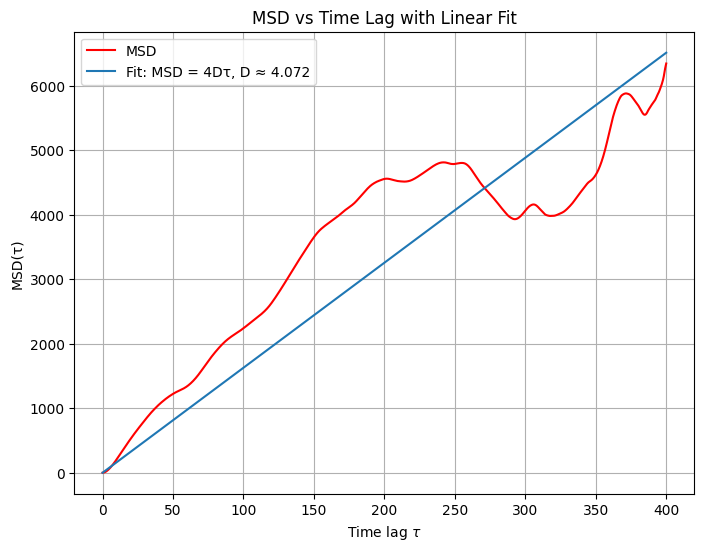

Estimated Diffusion Coefficient D: 4.071825236745412


In [4]:
from scipy.optimize import curve_fit


# Define a linear model for fitting
def linear_model(tau, D):
    return 4 * D * tau

# Perform the curve fitting
params, covariance = curve_fit(linear_model, msd_times, msd_values)

# Extract the estimated diffusion coefficient
D_estimate = params[0]  # This is D

# Plot the MSD vs tau with the fit
plt.figure(figsize=(8, 6))
plt.plot(msd_times, msd_values, label='MSD', color = "red" )
plt.plot(msd_times, linear_model(msd_times, D_estimate), '-', label=f'Fit: MSD = 4Dτ, D ≈ {D_estimate:.3f}')
plt.xlabel(r'Time lag $\tau$')
plt.ylabel('MSD(τ)')
plt.title('MSD vs Time Lag with Linear Fit')
plt.legend()
plt.grid()
plt.show()

print(f"Estimated Diffusion Coefficient D: {D_estimate}")


#### **Exercise 2. Magnetic susceptibility of the 2-d Ising model**
**Task 1.** In this task we show that the 2D Ising model behaves like a paramagnetic material at temperatures
T higher than its critical temperature (e.g., $T > T_c ≈ 2.269$).
Set $T = 5$. Calculate the total magnetization of the system as a function of H. We suggest you to use
the following values for $H$:
$H = −5, −2, −1, −0.5, −0.2, −0.1, 0, 0.1, 0.2, 0.5, 1, 2, 5$.
Moreover, as the magnetization fluctuates in time around an average value due to $T$ , we suggest to calculate
the magnetization m as an average on the last ≈ 100-300 iterations.

In [9]:
N = 100  # Size of the splin lattice.
H = 0  # External field.
J = 1  # Spin-spin coupling.
T = 5  # Temperature. Temperatura critica ~2.269.

sl = 2 * np.random.randint(2, size=(N, N)) - 1

N_up = np.sum(sl + 1) / 2
N_down = N * N - N_up

print(f"Spin lattice created:  N_up={N_up}  N_down={N_down}")

Spin lattice created:  N_up=5069.0  N_down=4931.0


In [10]:
def neighboring_spins(i_list, j_list, sl):
    """
    Function returning the position of the neighbouring spins of a list of 
    spins identified by their positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """

    Ni, Nj = sl.shape  # Shape of the spin lattice.
    
    # Position neighbors right.
    i_r = i_list  
    j_r = list(map(lambda x:(x + 1) % Nj, j_list))   

    # Position neighbors left.
    i_l = i_list  
    j_l = list(map(lambda x:(x - 1) % Nj, j_list))   

    # Position neighbors up.
    i_u = list(map(lambda x:(x - 1) % Ni, i_list))  
    j_u = j_list  

    # Position neighbors down.
    i_d = list(map(lambda x:(x + 1) % Ni, i_list)) 
    j_d = j_list   

    # Spin values.
    sl_u = sl[i_u, j_u]
    sl_d = sl[i_d, j_d]
    sl_l = sl[i_l, j_l]
    sl_r = sl[i_r, j_r]

    return sl_u, sl_d, sl_l, sl_r

In [11]:
def energies_spins(i_list, j_list, sl, H, J):
    """
    Function returning the energies of the states for the spins in given 
    positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """
    
    sl_u, sl_d, sl_l, sl_r = neighboring_spins(i_list, j_list, sl)
    
    sl_s = sl_u + sl_d + sl_l + sl_r 
    
    E_u = - H - J * sl_s
    E_d =   H + J * sl_s 
    
    return E_u, E_d

In [12]:
def probabilities_spins(i_list, j_list, sl, H, J, T):
    """
    Function returning the energies of the states for the spins in given 
    positions in the spin lattice.
    
    Parameters
    ==========
    i_list : Spin position first indices.
    j_list : Spin position second indices.
    sl : Spin lattice.
    """
    
    E_u, E_d = energies_spins(i_list, j_list, sl, H, J)
    
    Ei = np.array([E_u, E_d])
    
    Z = np.sum(np.exp(- Ei / T), axis=0)  # Partition function.
    pi = 1 / np.array([Z, Z]) * np.exp(- Ei / T)  # Probability.

    return pi, Z       


#### **P1** - plot $m(H)$

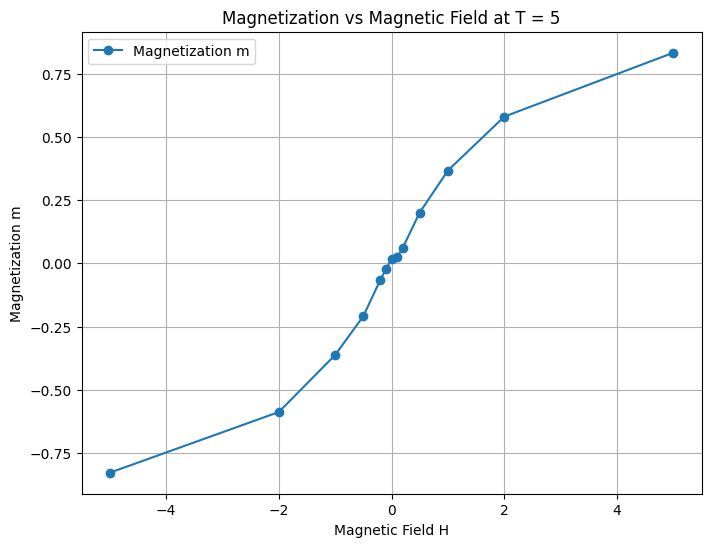

In [14]:
import random
import time

f = 0.05  # Number of randomly selected spins to flip-test.

num_iterations = 200

H_vals = [-5, -2, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 2, 5]
m_vals = []
Nspins = np.size(sl)  # Total number of spins in the spin lattice.
Ni, Nj = sl.shape

S = int(np.ceil(Nspins * f))  # Number of randomly selected spins.

for h in H_vals:
    m_tot = 0
    H = h
    sl = 2 * np.random.randint(2, size=(N, N)) - 1
    for i in range(num_iterations):
        ns = random.sample(range(Nspins), S)

        i_list = list(map(lambda x: x % Ni, ns)) 
        j_list = list(map(lambda x: x // Ni, ns)) 

        pi, Z = probabilities_spins(i_list, j_list, sl, H, J, T)

        rn = np.random.rand(S)
        for i in range(S):
            if rn[i] > pi[0, i]:
                sl[i_list[i], j_list[i]] = -1
            else:
                sl[i_list[i], j_list[i]] = 1
        m_tot += np.sum(sl) / (N**2)
    m_vals.append(m_tot / num_iterations)

# Plot m(H)
plt.figure(figsize=(8, 6))
plt.plot(H_vals, m_vals, 'o-', label="Magnetization m")
plt.xlabel("Magnetic Field H")
plt.ylabel("Magnetization m")
plt.title("Magnetization vs Magnetic Field at T = 5")
plt.legend()
plt.grid()
plt.show()





#### **Q1** - Calculate $\chi$.

In [16]:
from scipy.stats import linregress

# Use small H values for linear fit
small_H_indices = [i for i, H in enumerate(H_vals) if -0.5 <= H <= 0.5]
H_small = np.array([H_vals[i] for i in small_H_indices])
m_small = np.array([m_vals[i] for i in small_H_indices])

# Calculate slope (susceptibility)
slope, intercept, r_value, p_value, std_err = linregress(H_small, m_small)
chi = slope

print(f"Magnetic Susceptibility χ ≈ {chi}")

Magnetic Susceptibility χ ≈ 0.39206516666666663


#### **Task 2.** 
In this exercise we aim at finding the critical temperature of the Ising model by monitoring the
behavior of the absolute magnetization $\vert m \vert$ at $H = 0$ as a function of the temperature $T$. See reference figure
in the book Fig. 2.5. [Note: To obtain a figure like Fig. 2.5, you have to simulate for at least $10^5$ steps for each
value of the temperature, as explained in the book. In this task, we will use an alternative method that provides
a good first estimate of the critical temperature with significantly less iterations.]
Set the temperature $T$. We suggest you to use the following values for $T$:
$T = 0.1, 0.2, 0.5, 1, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 5.$
For each value of the temperature, start from a random state and perform 5000 iterations.
For the first 300 iterations, set $H = 0.1$.
For the remaining iterations, set $H = 0$.
After reaching the last iteration for a given $T$ , calculate the total magnetization of the system $m(T)$

##### **P2** - Plot $m(T)$

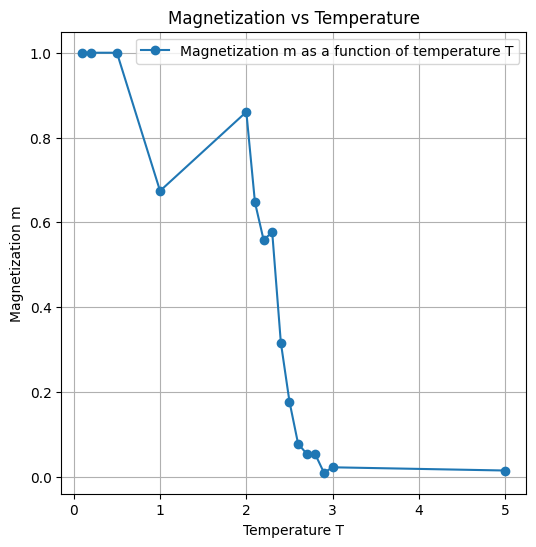

In [21]:
import random

f = 0.05  # Number of randomly selected spins to flip-test.

H = 0.1
num_iterations = 5000
T_vals = [0.1, 0.2, 0.5, 1, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 5]
m_vals = []
Nspins = np.size(sl)  # Total number of spins in the spin lattice.
Ni, Nj = sl.shape

S = int(np.ceil(Nspins * f))  # Number of randomly selected spins.

for t in T_vals:
    T = t
    H = 0.1
    sl = 2 * np.random.randint(2, size=(N, N)) - 1
    for i in range(num_iterations):
        if i == 300:
            H = 0
        
        ns = random.sample(range(Nspins), S)

        i_list = list(map(lambda x: x % Ni, ns)) 
        j_list = list(map(lambda x: x // Ni, ns)) 

        pi, Z = probabilities_spins(i_list, j_list, sl, H, J, T)

        rn = np.random.rand(S)
        for i in range(S):
            if rn[i] > pi[0, i]:
                sl[i_list[i], j_list[i]] = -1
            else:
                sl[i_list[i], j_list[i]] = 1
    
    m = np.sum(sl) / N**2
    m_vals.append(m)

# Plot m(H)
plt.figure(figsize=(6, 6))
plt.plot(T_vals, m_vals, 'o-', label="Magnetization m as a function of temperature T")
plt.xlabel("Temperature T")
plt.ylabel("Magnetization m")
plt.title("Magnetization vs Temperature for H = 0")
plt.legend()
plt.grid()
plt.show()



#### **Q2** - Estimate $T_c$ from your graph and explain your reasoning. Compare with theoretical value $T=2.269...$

For temperatures lower than $T_c$ we expect the magnetization to be higher as the spins align, on the other hand for temperatures higher than $T_c$ we expect the spins to be random and hence cancel each other out making the magnetization approach 0.
Therefore $T_c$ should be located where the system undergoes a phase transition from high magnetization to $\approx 0$ magnetization. In other words where the magnetization makes a steep drop to 0.

In our plot the steep drop seems start at $T=2.1$ and end around $T=2.5$, so $T_c \in [2.1,2.5]$, and perhaps it would make sense to think it is somewhere close to the middle of the interval so $T_c \approx 2.3$. Which is (surprisingly) a very good approximation based on the theoretical value considering the little work done here as opposed to in the text book.

#### **Exercise 3. Exponent $\alpha$ for a forest fire model and extrapolation to $N = \infty $**

In this exercise, we will try to extrapolate the exponent $\alpha$ in the case of very large $N$ , even beyond what we
can simulate with our computational resources. Choose $p = 0.01$, $f = 0.2.$ Make sure to simulate long enough
to collect at least 300 fire events.
Set $N$ equal to 16, 32, 64, 128, 256, 512, 1024. For each case, run a simulation and find the value of the exponent $\alpha$. In order to reduce noise, repeat each case 10 times and take the average $\alpha$. [Note: if the case N = 1024 is too slow, do less repetitions].
Let us call these different numbers by $\alpha_{16}, \alpha_{32}$ and so on.

##### **P1** - PLot the exponents $\alpha_N$ as a function of $N^{-1}$ as shoin in Fig. 3.6 of the book.

In [3]:

import numpy as np 
    
def grow_trees(forest, p):
    """
    Function to pgrow new trees in the forest.
    
    Parameters
    ==========
    forest : 2-dimensional array.
    p : Probability for a tree to be generated in an empty cell.
    """
    
    Ni, Nj = forest.shape  # Dimensions of the forest.
    
    new_trees = np.random.rand(Ni, Nj)

    new_trees_indices = np.where(new_trees <= p)
    forest[new_trees_indices] = 1
    
    return forest

In [4]:
def propagate_fire(forest, i0, j0):
    """
    Function to propagate the fire on a populated forest.
    
    Parameters
    ==========
    forest : 2-dimensional array.
    i0 : First index of the cell where the fire occurs.
    j0 : Second index of the cell where the fire occurs.
    """
    
    Ni, Nj = forest.shape  # Dimensions of the forest.

    fs = 0  # Initialize fire size.

    if forest[i0, j0] == 1:
        active_i = [i0]  # Initialize the list.
        active_j = [j0]  # Tnitialize the list. 
        forest[i0, j0] = -1  # Sets the tree on fire.
        fs += 1  # Update fire size.
        
        while len(active_i) > 0:
            next_i = []
            next_j = []
            for n in np.arange(len(active_i)):
                # Coordinates of cell up.
                i = (active_i[n] + 1) % Ni
                j = active_j[n]
                # Check status
                if forest[i, j] == 1:
                    next_i.append(i)  # Add to list.
                    next_j.append(j)  # Add to list.
                    forest[i, j] = -1  # Sets the current tree on fire.
                    fs += 1  # Update fire size.

                # Coordinates of cell down.
                i = (active_i[n] - 1) % Ni
                j = active_j[n]
                # Check status
                if forest[i, j] == 1:
                    next_i.append(i)  # Add to list.
                    next_j.append(j)  # Add to list.
                    forest[i, j] = -1  # Sets the current tree on fire.
                    fs += 1  # Update fire size.

                # Coordinates of cell left.
                i = active_i[n]
                j = (active_j[n] - 1) % Nj
                # Check status
                if forest[i, j] == 1:
                    next_i.append(i)  # Add to list.
                    next_j.append(j)  # Add to list.
                    forest[i, j] = -1  # Sets the current tree on fire.
                    fs += 1  # Update fire size.

                # Coordinates of cell right.
                i = active_i[n]
                j = (active_j[n] + 1) % Nj
                # Check status
                if forest[i, j] == 1:
                    next_i.append(i)  # Add to list.
                    next_j.append(j)  # Add to list.
                    forest[i, j] = -1  # Sets the current tree on fire.
                    fs += 1  # Update fire size.

            active_i = next_i
            active_j = next_j        
            
    return fs, forest


In [5]:

def complementary_CDF(f, f_max):
    """
    Function to return the complementary cumulative distribution function.
    
    Parameters
    ==========
    f : Sequence of values (as they occur, non necessarily sorted).
    f_max : Integer. Maximum possible value for the values in f. 
    """
    
    num_events = len(f)
    s = np.sort(np.array(f)) / f_max  # Sort f in ascending order.
    c = np.array(np.arange(num_events, 0, -1)) / (num_events)  # Descending.
    
    c_CDF = c
    s_rel = s

    return c_CDF, s_rel

In [7]:

N = 100  # Side of the forest.
p = 0.01  # Growth probability.
f = 0.2  # Lightning strike probability.
target_num_fires = 300
N_vals = [16, 32, 64, 128, 256, 512, 1024]
N_inverse = [1 / n for n in N_vals]
alpha_vals = [0.0] * len(N_vals)


num_fires = 0
n_count = 0
for n in N_vals:
    N = n
    for i in range(10):
        forest = np.zeros([N, N])  # Empty forest.
        Ni, Nj = forest.shape  # Sets the variables describing the shape.
        fire_size = []  # Empty list of fire sizes.
        fire_history = []  # Empty list of fire history.
        num_fires = 0
        while num_fires < target_num_fires:

            forest = grow_trees(forest, p)  # Grow new trees.
            
            p_lightning = np.random.rand()
            if p_lightning < f:  # Lightning occurs.
                i0 = np.random.randint(Ni)
                j0 = np.random.randint(Nj)
                
                fs, forest = propagate_fire(forest, i0, j0)
                if fs > 0:
                    fire_size.append(fs) 
                    num_fires += 1 
                    
                fire_history.append(fs)
                
            else:
                fire_history.append(0)

            forest[np.where(forest == -1)] = 0


        c_CDF, s_rel = complementary_CDF(fire_size, forest.size)

        min_rel_size = 1e-3
        max_rel_size = 1e-1


        is_min = np.searchsorted(s_rel, min_rel_size)
        is_max = np.searchsorted(s_rel, max_rel_size)

# Note!!! The linear dependence is between the logarithms
        polyfit = np.polyfit(np.log(s_rel[is_min:is_max]),
                    np.log(c_CDF[is_min:is_max]), 1)

        beta = polyfit[0]

        alpha = 1 - beta
        alpha_vals[n_count] += alpha
    print("Done with N = ", n)
    n_count += 1

alpha_vals = [a / 10 for a in alpha_vals]
print(alpha_vals)


Done with N =  16
Done with N =  32
Done with N =  64
Done with N =  128
Done with N =  256
Done with N =  512
Done with N =  1024
[np.float64(1.3153131721656162), np.float64(1.2906344344458154), np.float64(1.2625097096235496), np.float64(1.218151436924842), np.float64(1.1807274698926638), np.float64(1.149914331153671), np.float64(1.1144351222480182)]


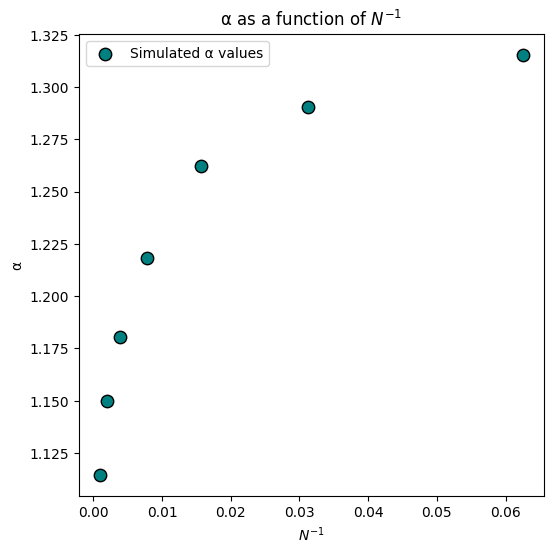

In [8]:
import matplotlib.pyplot as plt

# Plot α_N as a function of N^{-1}
plt.figure(figsize=(6, 6))
plt.scatter(N_inverse, alpha_vals, color="teal", s=80, edgecolor="black", marker='o', label='Simulated α values')
plt.xlabel('$N^{-1}$')
plt.ylabel('α')
plt.title('α as a function of $N^{-1}$')
plt.legend()
plt.show()

##### **Q1** - Extrapolate your results to $N^{-1} \lim 0$. Explain the reason for your choice of the fitting function and provide your extrapolation for $\alpha_{\infty}$. Compare your plot and your fitting procedure with Figs. 3.6.

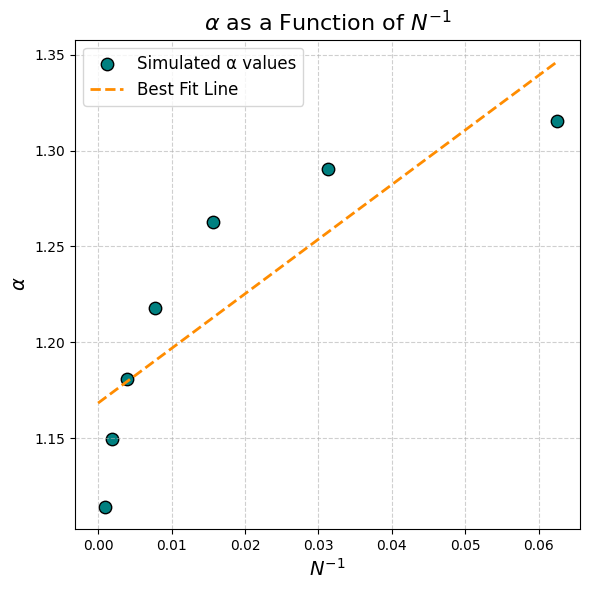

alpha_inf is approx  1.1683884980066812


In [18]:
# Linear fit for extrapolation (optional)
fit = np.polyfit(N_inverse, alpha_vals, 1)
fit_func = np.poly1d(fit)
t = np.linspace(0,1/16, 100)
# Create the plot
plt.figure(figsize=(6, 6))
plt.scatter(N_inverse, alpha_vals, color="teal", s=80, edgecolor="black", marker='o', label='Simulated α values')
plt.plot(t, fit_func(t), '--', color='darkorange', linewidth=2, label="Best Fit Line")
plt.xlabel(r'$N^{-1}$', fontsize=14)

plt.ylabel(r'$\alpha$', fontsize=14)
plt.title(r'$\alpha$ as a Function of $N^{-1}$', fontsize=16)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("alpha_inf is approx ", fit_func(0))

I choose a linear fit because for polynomials of degree $n> 1$ the polynomial fit looks goofy. By goofy I mean the fit increases/decreases in places we would not expect $\alpha$ to do so (such as between the first two choices of $N$). A linear relation also makes sense intuitively as the system should be scale-invariant.

Comparing my plot to the one in the book I can see that my data points are more "sporadic" and don't give as great of a linear fit. Most likely because I used a quite low cap of how many fires to record (300) before ending the simulation due to computational retardation of python. All in all they are quite similar in the end, same fitting used. 

Could also argue the linear term dominates since we are approaching 0.
  

##### **Q2** - How does the value estimated in the previous point relate to the estimate $\alpha = 1.15$ given in Chap 3.

My approximation of $\alpha \approx 1.168$ has the percent error of $\approx 1.6\%$ compared to the theoretical value, which is pretty remarkable. Considering the low cap of fires to record (300) before ending the simulation I did not expect it to come so close. All in all for a first estimate it's not too shabby.

#### **Exercise 4.** Simulate the game of life on a lattice N × N , as shown in class. Start from a random configuration. Use periodic boundary conditions. Set N = 100 or larger. In each run, let the system evolve for at least T = 300 time steps. Perform at least 5 runs starting from different random configurations.

##### **Task 1:** For each run, record the number of live cells A as a function of the time step $t$.

In [2]:

def neighbors_Moore(status):
    """
    Function to return the number of neighbors for each cell in status.
    
    Parameters
    ==========
    status : Current status.
    """

    # Initialize the neighbor count array
    n_nn = (
        np.roll(status, 1, axis=0) +  # Up.
        np.roll(status, -1, axis=0) +  # Down.
        np.roll(status, 1, axis=1) +  # Left.
        np.roll(status, -1, axis=1) +  # Right.
        np.roll(np.roll(status, 1, axis=0), 1, axis=1) +  # Up-Left.
        np.roll(np.roll(status, 1, axis=0), -1, axis=1) +  # Up-Right
        np.roll(np.roll(status, -1, axis=0), 1, axis=1) +  # Down-Left
        np.roll(np.roll(status, -1, axis=0), -1, axis=1)  # Down-Right
    )

    return n_nn

In [3]:

def apply_rule_2d(rule_2d, status):
    """
    Function to apply a 2-d rule on a status. Return the next status.
    
    Parameters
    ==========
    rule_2d : Array with size [2, 9]. Describe the CA rule.
    status : Current status.
    """
    
    Ni, Nj = status.shape  # Dimensions of 2-D lattice of the CA.
    next_status = np.zeros([Ni, Nj]) 
    
    # Find the number of neighbors.
    n_nn = neighbors_Moore(status) 
    for i in range(Ni):
        for j in range(Nj):
            next_status[i, j] = rule_2d[int(status[i, j]), int(n_nn[i, j])]
        
    return next_status

In [9]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
T = 300
A_for_diff_runs = []
# Random initial state.
gol = np.random.randint(2, size=[N, N])

rule_2d = np.zeros([2, 9])
# Game of Life's rules.
rule_2d[0, :] = [0, 0, 0, 1, 0, 0, 0, 0, 0]  # New born from empty cell.
rule_2d[1, :] = [0, 0, 1, 1, 0, 0, 0, 0, 0]  # Survival from living cell.

Ni, Nj = gol.shape  # Sets the variables describing the shape.

for n in range(10):
    A_temp = [0]*T
    gol = np.random.randint(2, size=[N, N])
    for i in range(T):
        gol = apply_rule_2d(rule_2d, gol)
        A_temp[i] += np.sum(gol)
    A_for_diff_runs.append(A_temp)
    



##### **P1** - Plot A(t) for the different runs.

C:\Users\Viggo\AppData\Local\Temp\ipykernel_17256\1232690602.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


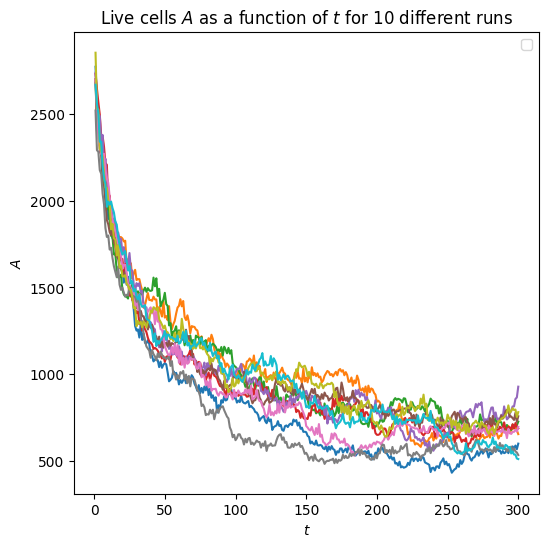

In [10]:

plt.figure(figsize=(6, 6))
for A in A_for_diff_runs:
    plt.plot(range(1,T+1), A)

plt.xlabel('$t$')
plt.ylabel('$A$')
plt.title('Live cells $A$ as a function of $t$ for 10 different runs')
plt.legend()
plt.show()


##### **Q1** - What is the average density of alive cell per unit area for the game of life?

In [ ]:
mean_dens_for_diff_runs = []

for A in A_for_diff_runs:
    mean_tmp = 0
    for cell_count in A:
        mean_tmp += cell_count / (N*N)
    mean_tmp = mean_tmp / T
    mean_dens_for_diff_runs.append(mean_tmp)

mean_dens = np.mean(mean_dens_for_diff_runs)
print(mean_dens)

average_density = np.mean([np.mean(A_t) / (N**2) for A_t in A_for_diff_runs])
print(average_density) 
print("About 10% of board contains an alive cell")

        


0.09431276666666666
0.09431276666666667
So about 10% of area has a cell


##### **Q2** - After *approximately* how many iterations a *steady state* with average density is reached, from the initial random configuration

C:\Users\Viggo\AppData\Local\Temp\ipykernel_17256\1598590643.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


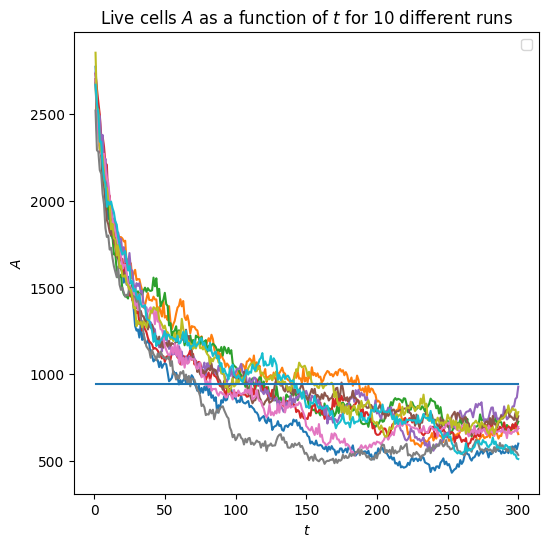

In [18]:

plt.figure(figsize=(6, 6))
for A in A_for_diff_runs:
    plt.plot(range(1,T+1), A)


plt.plot(range(1, T + 1), np.ones(T)*mean_dens*N**2)
plt.xlabel('$t$')
plt.ylabel('$A$')
plt.title('Live cells $A$ as a function of $t$ for 10 different runs')
plt.legend()
plt.show()


After about 100 iterations the different random configurations seem to reach the average density and stay close to it aka steady state.

#### **Task 2:** For each run, monitor the changes in the configuration of the game of life. After the initial transient has passed and the configuration is settle down around its average density, record, for each time step t, how many cells C change their state in the following time step (i.e., how many cells that were alive die and how many empty cells generate a new live cell.)
##### **P2** - Plot C(t) for the different runs.

C:\Users\Viggo\AppData\Local\Temp\ipykernel_12604\2012611198.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


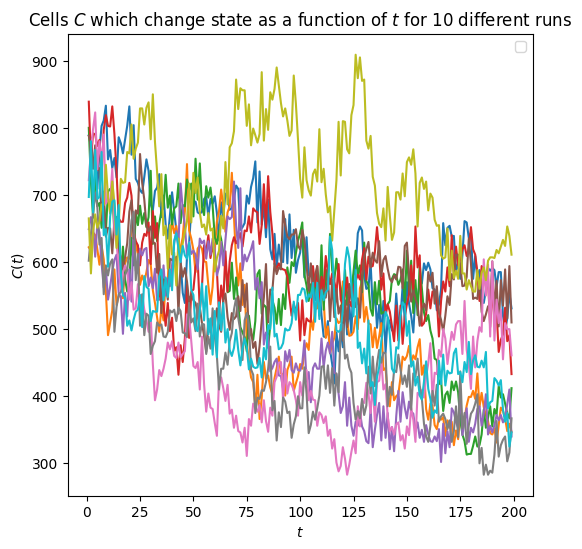

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

N = 100
T = 300
C_for_diff_runs = []
# Random initial state.
gol = np.random.randint(2, size=[N, N])

rule_2d = np.zeros([2, 9])
# Game of Life's rules.
rule_2d[0, :] = [0, 0, 0, 1, 0, 0, 0, 0, 0]  # New born from empty cell.
rule_2d[1, :] = [0, 0, 1, 1, 0, 0, 0, 0, 0]  # Survival from living cell.

Ni, Nj = gol.shape  # Sets the variables describing the shape.

for n in range(10):
    C_t = []
    gol = np.random.randint(2, size=[N, N])
    for t in range(T):
        new_gol = apply_rule_2d(rule_2d, gol)
        if (t > 100):
            diff_grid = new_gol - gol #Get grid with 1 if dead-> alive, 0 if no change, -1 if alive -> dead
            change_grid = np.abs(diff_grid) #Don't care for 1 or -1 just want count
            change_count = np.sum(change_grid)
            C_t.append(change_count)

        gol = new_gol
    
    C_for_diff_runs.append(C_t)
    



plt.figure(figsize=(6, 6))
for C_t in C_for_diff_runs:
    plt.plot(range(1,T - 100), C_t)

plt.xlabel('$t$')
plt.ylabel('$C(t)$')
plt.title('Cells $C$ which change state as a function of $t$ for 10 different runs')
plt.legend()
plt.show()